# Imports, api, datasets and functions to use Naswot metric

In [ ]:
!pip install nats_bench
!wget "https://www.dropbox.com/sh/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar"
!tar -xf "NATS-tss-v1_0-3ffb9-simple.tar"

!pip install xautodl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-06-10 08:41:54--  https://www.dropbox.com/sh/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar [following]
--2022-06-10 08:41:54--  https://www.dropbox.com/sh/raw/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3ac634d36213bd06ae319e3115.dl.dropboxusercontent.com/cd/0/inline/Bm4chHqunteKcG-93HwuLK9C5kYrqB-gkpicp6qksy_Hw4peSdTIWejQEVMP0O1K4otiljJiGomIyKrwLVr1GHyG9va9al1DQuuj9TLRCwfGgAlahntOzvFATuDR

In [ ]:
!wget 'https://www.dropbox.com/s/o2fg17ipz57nru1/?dl=1' -O ImageNet16.tar.gz
!tar -xf "ImageNet16.tar.gz"

--2022-06-10 08:43:16--  https://www.dropbox.com/s/o2fg17ipz57nru1/?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/o2fg17ipz57nru1 [following]
--2022-06-10 08:43:16--  https://www.dropbox.com/s/dl/o2fg17ipz57nru1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1ad5f1e91ecd2f608ef47c408b.dl-eu.dropboxusercontent.com/cd/0/get/Bm5pV_v6GC_qCygUjfHGcX1s_CchUV8zC0F9wtkz2d6XCw4lihbF4VMjm7A6S3iQADs8cevJigob4n06BdEsQrlLfFkgaGIHKhrHkkuYRmijbvDdaHJI1vyIVhf-Jad3sXOw0npQJdRrt1wSUOY9BkT_EKEtgHbpdIQFYGyc1Qv-PQ7y216Zl94OAPXDhTdpNKc/file?dl=1# [following]
--2022-06-10 08:43:17--  https://uc1ad5f1e91ecd2f608ef47c408b.dl-eu.dropboxusercontent.com/cd/0/get/Bm5pV_v6GC_qCygUjfHGcX1s_CchUV8zC0F9wtkz2d6XCw4lihbF4VMjm7A6S3iQADs8cevJig

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from xautodl.datasets.DownsampledImageNet import ImageNet16
from torchvision import transforms
import numpy as np
import torch
import operator
from numba import cuda
from nats_bench import create
from xautodl.models import get_cell_based_tiny_net
import random
import pandas as pd
import os
from scipy import stats
import time
import operator
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Create the API instance for the size search space in NATS
api = create("/content/NATS-tss-v1_0-3ffb9-simple/", 'tss', fast_mode=True, verbose=False)

#tranforms to tensor the input data, no data augmentation needed
transform = transforms.Compose([
    transforms.ToTensor()
])

#funtion to retrieve the train loader
def get_data(dataset, batch_size, pin_memory=True):
  transform = transforms.Compose([
    transforms.ToTensor() ])
  if dataset == 'cifar10':
    train_data = dset.CIFAR10 ("/content/Cifar10", train=True ,transform = transform, download=True)

  elif dataset == 'cifar100':
    train_data = dset.CIFAR100("/content/Cifar100", train=True ,transform = transform, download=True)
    
  elif dataset == 'ImageNet16-120':
    train_data = ImageNet16("/content/ImageNet16", True, transform = transform)

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=pin_memory)
  
  return train_loader


In [ ]:
#log of kernel function
def logdet(K):
    s, ld = np.linalg.slogdet(K)
    return ld

#weight initialization function
def init(m):
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)

# function to compute Hamming Distance, using cuda jit library
# A is the binary codification of the current Relu output
# C is the hamming distance (result of this function) 
@cuda.jit
def constructK(A,C):
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += operator.xor(bool(A[i, k]),bool(A[j, k]))
        C[i, j] = tmp

In [ ]:
# hook registered on forward in each Relu instance of the network
# here we binarize the output of Relu, setup the parameters to parallelize with cuda.jit
# construct the kernel matrix
def counting_forward_hook(module, inp, out):
  if isinstance(inp, tuple):
    inp = inp[0]
  inp = inp.view(inp.size(0), -1)
  inp = (inp > 0).float()

  inp = cuda.to_device(inp)
  temp = cuda.device_array((inp.shape[0], inp.shape[0]))

  threadsperblock = (8,8)
  blockspergrid = (16,16)

# Start the kernel 
  constructK[blockspergrid, threadsperblock](inp, temp)

# Copy the result back to the host
  global Ktemp, device
  temp = torch.tensor(temp.copy_to_host()).to(device)
  temp = inp.shape[1]-temp
  Ktemp = Ktemp + temp


In [ ]:
# dictionary that registers isomorphisms, useful to compute score only in the unique models
networks = {}
ids = []

for i in range(len(api)):
  # we use get_unique_str() that return a string unique for every isomorphism
  net = api.get_unique_str(i)
  if net not in networks.keys():
    networks[net] = [i]
    ids.append(i)
  else :
    networks[net].append(i)

nets = {}
for k,v in networks.items():
  if len(v) > 1:
    nets[v[0]] = v[1:]
  else:
    nets[v[0]] = []

del networks

ids = np.array(ids)

#Compute score for all the network
Only in the unique networks, no isomorphisms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
datasetNames = ['cifar10','cifar100','ImageNet16-120']

batch_size = 128 

for dataset in datasetNames:
  
  train_loader = get_data(dataset, batch_size)
  
  # we compute the score only for the unique architectures
  for i in ids:
    
    start = time.time()

    config = api.get_net_config(i, dataset)
    network = get_cell_based_tiny_net(config)
    network.apply(init)

    for name, module in network.named_modules():
      if (isinstance(module, torch.nn.modules.activation.ReLU)):
        # register on each Relu a forward hook
        module.register_forward_hook(counting_forward_hook)
  
    network = network.to(device)

    # initialize the kernel matrix
    Ktemp = torch.tensor(np.zeros((batch_size,batch_size))).to(device)
    data_iterator = iter(train_loader)
    x, target = next(data_iterator)
    x, target = x.to(device), target.to(device)
    # forward data to network 
    network(x)
    # log of the determinant
    score = logdet(Ktemp.cpu().detach().numpy(), target)
    
    del Ktemp, network, data_iterator

    acc = api.get_more_info(int(i),dataset,is_random=False,hp=200)["test-accuracy"]
    
    # considering time to compute the score
    tempo = time.time()-start
    csv_dict = {'Dataset': dataset, 'Network': i, 'Metric': score, 'Accuracy': acc, 'Time': tempo}
    result = pd.DataFrame([csv_dict])
    result.to_csv('out.csv', mode='a', index=False, header=False )
    del result

    #replicate score in isomorphisms
    for net in nets[i]:

      csv_dict = {'Dataset': dataset, 'Network': net, 'Metric': score, 'Accuracy': acc, 'Time': tempo}
      result = pd.DataFrame([csv_dict])
      result.to_csv('out.csv', mode='a', index=False, header=False )
      del result


#Table times per batch size

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
datasetNames = 'cifar10' #fixed the dataset

batch_sizes = [8,16,64,128,256,512] 
iterations = 20
i = 544 #fixed the model

config = api.get_net_config(i, dataset)
network = get_cell_based_tiny_net(config)
network.apply(init)

for name, module in network.named_modules():
  if (isinstance(module, torch.nn.modules.activation.ReLU)):
    module.register_forward_hook(counting_forward_hook)

network = network.to(device)

for batch_size in batch_sizes:
  
  train_loader = get_data(dataset, batch_size)
  
  for j in range(iterations):
    
    start = time.time()

    network.apply(init)

    Ktemp = torch.tensor(np.zeros((batch_size,batch_size))).to(device)
    data_iterator = iter(train_loader)
    x, target = next(data_iterator)
    x, target = x.to(device), target.to(device)
    network(x)
    score = logdet(Ktemp.cpu().detach().numpy(), target)
    
    del Ktemp, data_iterator

    acc = api.get_more_info(int(i),dataset,is_random=False,hp=200)["test-accuracy"]
    tempo = time.time()-start
    csv_dict = {'Dataset': dataset, 'Network': i, 'Metric': score, 'Accuracy': acc, 'Time': tempo, 'size': batch_size}
    result = pd.DataFrame([csv_dict])
    result.to_csv('out.csv', mode='a', index=False, header=False )


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
strfile = f'/content/out.csv'
csv_df = pd.read_csv(strfile,names = ['Dataset','Network','Metric','Accuracy','Time','size'],header = None, index_col=['Dataset'])

In [ ]:
csv_df.groupby('size')['Time'].describe()[['mean','std']].to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &      mean &       std \\\\\nsize &           &           \\\\\n\\midrule\n8    &  0.156775 &  0.024288 \\\\\n16   &  0.151437 &  0.002760 \\\\\n64   &  0.181524 &  0.004438 \\\\\n128  &  0.258984 &  0.003784 \\\\\n256  &  0.316564 &  0.007100 \\\\\n512  &  0.462246 &  0.005050 \\\\\n\\bottomrule\n\\end{tabular}\n'

#Table score per number of relu

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = 'cifar10'

batch_size = 128 
num = 300 # number of model to consider

mask = np.random.randint(0,len(ids),num) # we pick randomly 300 models
ids = ids[mask]

train_loader = get_data(dataset, batch_size)

for i in ids:
  
  start = time.time()

  counter = 0 # useful to know the number of Relu 
  config = api.get_net_config(i, dataset)
  network = get_cell_based_tiny_net(config)
  network.apply(init)

  for name, module in network.named_modules():
    if (isinstance(module, torch.nn.modules.activation.ReLU)):
      counter += 1
      module.register_forward_hook(counting_forward_hook)

  network = network.to(device)

  Ktemp = torch.tensor(np.zeros((batch_size,batch_size))).to(device)
  data_iterator = iter(train_loader)
  x, target = next(data_iterator)
  x, target = x.to(device), target.to(device)
  network(x)
  score = logdet(Ktemp.cpu().detach().numpy(), target)
  
  del Ktemp, network, data_iterator

  acc = api.get_more_info(int(i),dataset,is_random=False,hp=200)["test-accuracy"]
  tempo = time.time()-start
  csv_dict = {'Dataset': dataset, 'Network': i, 'Metric': score, 'Accuracy': acc, 'Time': tempo, 'relu': counter}
  result = pd.DataFrame([csv_dict])
  result.to_csv('out.csv', mode='a', index=False, header=False )

  

Files already downloaded and verified


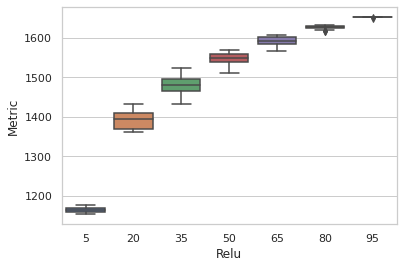

In [ ]:
strfile = f'/content/out.csv'
csv_df = pd.read_csv(strfile,names = ['Dataset','Network','Metric','Accuracy','Time','Relu'],header = None, index_col=['Dataset'])

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Relu", y="Metric", data=csv_df)
plt.savefig('relu.pdf',dpi=300,bbox_inches='tight')
